# Tiempo de permanencia de un usuario en la página


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import inline as inline

%matplotlib inline

pd.set_option('display.width', 400)
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 200)

plt.style.use('default') # haciendo los graficos un poco mas bonitos en matplotlib
#plt.rcParams['figure.figsize'] = (20, 10)

sns.set(style="whitegrid") # seteando tipo de grid en seaborn

df = pd.read_csv('events.csv')
pd.options.mode.chained_assignment = None

/home/carito/.local/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Me quedo solo con las columnas que son de interés para este análisis

In [2]:
df_tiempos=  df[['timestamp','person']]
df_tiempos['timestamp'] = pd.to_datetime(df_tiempos['timestamp'])
df_tiempos= df_tiempos.sort_values(by=["timestamp"])
df_tiempos['just_date'] = df_tiempos['timestamp'].dt.date
df_tiempos.reset_index(drop = True, inplace = True)

Agrego la columna **'diff'** que me indica _diferencia de tiempo entre los distintos eventos temporales **por usuario**_

In [3]:
df_tiempos['diff'] = df_tiempos.groupby(['person'])['timestamp'].diff()

Paso la columna a string para detectar los valores "NaT" que indican el ingreso de un nuevo usuario 

In [4]:
df_tiempos['diff'] = df_tiempos['diff'].astype(str)
df_tiempos['new_user'] = df_tiempos['diff'] =='NaT'

Agrego la columna **'diff2'** que me indica la _diferencia entre eventos temporales_ (sin importar el usuario)

In [5]:
df_tiempos['diff2'] = (df_tiempos['timestamp'] - (df_tiempos['timestamp'].shift())) / np.timedelta64(1, 'h')

Reasigno la columna **'diff'** para volver a tener datos de tipo temporal y elimina los nulos

In [6]:
df_tiempos['diff'] = df_tiempos.groupby(['person'])['timestamp'].diff()

Lleno con 0s todos los nulos del data frame

In [7]:
df_tiempos=df_tiempos.fillna(0)

Identifico en la columna **'new_session_same_user'** los _comienzos de nuevas sesiones del mismo usuario_. Para ello se tiene en cuenta un umbral de 0.48 horas. Es decir, se considera que si el tiempo entre eventos es mayor a 0.48 horas, el evento corresponde a una nueva sesion del mismo usuario. En el informe adjunto se explica detalladamente la elección de este umbral.

In [8]:
df_tiempos['new_session_same_user'] = df_tiempos['diff2'] > 0.48

Identifico en la columna **'new_session_new_user'** los comienzos de _nuevas sesiones de un usuario nuevo._ Se tiene en cuenta el mismo umbral que antes. 

In [9]:
df_tiempos["diff"]=df_tiempos["diff"]/np.timedelta64(1, 'h')
df_tiempos["new_session_new_user"] = df_tiempos["diff"] > 0.48

Para contabilizar las sesiones nuevas (que pueden corresponder al mismo usuario o a un nuevo usuario) se realiza la operacion OR entre las columnas con datos booleanos calculadas previamente.

In [10]:
df_tiempos["new_session"]=df_tiempos["new_user"]|df_tiempos["new_session_same_user"]|df_tiempos["new_session_new_user"]

Enumero las sesiones para luego separarlas por agrupación

In [11]:
df_tiempos['sessionid'] = df_tiempos['new_session'].cumsum()

Como pusimos un umbral de 0.48 horas para la finalizacion de las sesiones, elimino de la columa **'diff'** los valores que superen ese valor (Me quedo solo con los False de la columna new_sesion). Estos valores se corresponderan al primer 'diff' de cada sesion, que debería ser siempre nulo.

In [12]:
df_tiempos=df_tiempos[df_tiempos.new_session==False]

Ahora si agrupo por **sessionid** y obtengo la información buscada

In [13]:
df_tiempos

,timestamp,person,just_date,diff,new_user,diff2,new_session_same_user,new_session_new_user,new_session,sessionid
1,2018-01-01 07:32:26,9250d410,2018-01-01,0.000000,False,0.000000,False,False,False,1
2,2018-01-01 07:32:26,9250d410,2018-01-01,0.000000,False,0.000000,False,False,False,1
3,2018-01-01 07:32:26,9250d410,2018-01-01,0.000000,False,0.000000,False,False,False,1
5,2018-01-01 09:51:53,8b6dbd1d,2018-01-01,0.000556,False,0.000556,False,False,False,2
7,2018-01-01 12:40:21,8b6dbd1d,2018-01-01,0.000000,False,0.000000,False,False,False,3
8,2018-01-01 12:41:07,8b6dbd1d,2018-01-01,0.012778,False,0.012778,False,False,False,3
9,2018-01-01 12:41:34,8b6dbd1d,2018-01-01,0.007500,False,0.007500,False,False,False,3
10,2018-01-01 12:41:59,8b6dbd1d,2018-01-01,0.006944,False,0.006944,False,False,False,3
11,2018-01-01 12:42:34,8b6dbd1d,2018-01-01,0.009722,False,0.009722,False,False,False,3
12,2018-01-01 12:43:32,8b6dbd1d,2018-01-01,0.016111,False,0.016111,False,False,False,3


In [14]:
tiempos_sesiones=df_tiempos.groupby(["sessionid"]).agg({'diff':'sum'})

In [16]:
tiempos_sesiones

,diff
sessionid,
1,0.000000
2,0.000556
3,0.074722
4,0.000000
5,0.000000
6,0.077778
7,0.031667
8,0.000556
9,0.003056


In [15]:
df_tiempos["sessionid"].max()

89071

Es importante notar que el index de **session_id** nos indica que debemos tener 89071 sesiones, mientras que la cantidad de filas de 'tiempos_sesiones' es 86643, por lo que evidentemente hemos eliminado sesiones de evento único y duración nula, volvemos a agregarlas para que nuestro promedio no se vea afectado:

In [16]:
for i in range(86643,89071):
    tiempos_sesiones = tiempos_sesiones.append({'diff': 0}, ignore_index=True)

In [17]:
tiempos_sesiones.describe()

,diff
count,89071.000000
mean,0.119708
std,0.176241
min,0.000000
25%,0.008333
50%,0.047500
75%,0.155833
max,2.323889


<Figure size 432x288 with 0 Axes>

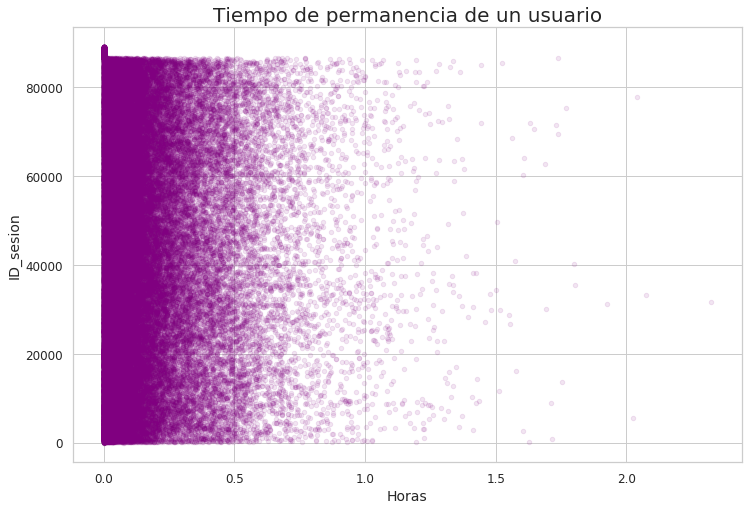

In [18]:
plt.figure()
g= tiempos_sesiones.reset_index().plot(kind='scatter', y='index', x='diff',alpha=0.1,figsize=(12,8),color='purple',title='Tiempo de permanencia de un usuario',legend=False,fontsize=12)


g.set_xlabel("Horas",fontsize=14)
g.set_ylabel("ID_sesion",fontsize=14)
g.title.set_size(20)
fig = g.get_figure()
fig.savefig('tiempo_sesiones.jpg')

# Tasa de rebote

Consideramos un tiempo de sesion satisfactorio de 30 segundos. Por lo tanto, calcularemos la tasa de rebote para aquellas sesiones menores a este lapso de tiempo. 30 seg = 0.00833 horas

In [19]:
tiempos_sesiones["menor_a_30_seg"] = tiempos_sesiones["diff"] < 0.00833

In [20]:
tiempos_sesiones.head(10)

,diff,menor_a_30_seg
0,0.000000,True
1,0.000556,True
2,0.074722,False
3,0.000000,True
4,0.000000,True
5,0.077778,False
6,0.031667,False
7,0.000556,True
8,0.003056,True
9,0.104444,False


In [21]:
tiempos_sesiones["menor_a_30_seg"].value_counts()

False    66825
True     22246
Name: menor_a_30_seg, dtype: int64

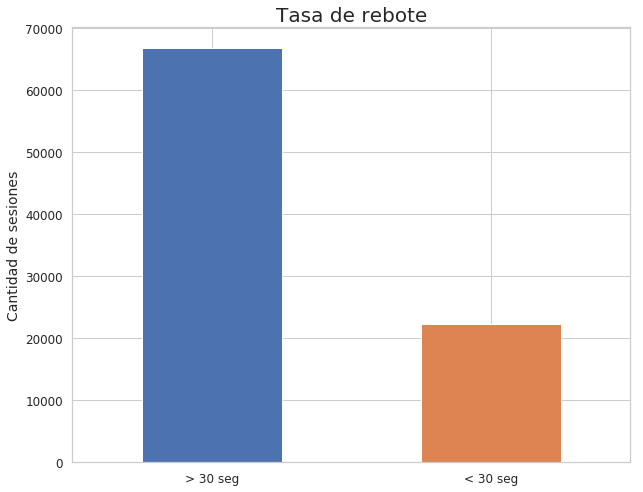

In [22]:
plt.figure()
g2=tiempos_sesiones["menor_a_30_seg"].value_counts().plot(kind='bar',figsize=(10,8),rot=0,title='Tasa de rebote',legend=False,fontsize=12)

g2.set_ylabel("Cantidad de sesiones",fontsize=14)
x_lab=['> 30 seg','< 30 seg']
g2.set_xticklabels(x_lab)
g2.title.set_size(20)
fig = g2.get_figure()
fig.savefig('tasa_rebote.jpg')